## Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, f1_score, confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

In [3]:
from sklearn.pipeline import Pipeline

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Funciones utilizadas en el notebook

In [5]:
def rellenar_missings(df : pd.DataFrame, price_col : str, target_col : str, days : int) -> pd.DataFrame:
    """
    Esta función se encarga de rellenar los valores missing que se encuentran en la columna
    del precio en un data frame de pandas. Los valores missing son rellenados calculando la 
    media entre el valor anterior y el posterior ya que se trata de una variable continua.
    Después, la variable target debe ser modificada en consecuencia a los valores que se hayan
    decidido introducir en los huecos de valores nulos.
    
    Parámetros:
    
    - df: Un pandas data frame que debe contener una columna target y una columna de precios.
    - price_col: El nombre de la columna de precios.
    - target_col: El nombre de la columna target.
    - days: El número de días que se tiene en cuenta para determinar si el precio sube o baja.
    
    Devuelve:
    
    - df: El df resultante después de la modificación de los valores missing.
    
    """
    
    assert price_col in df.columns and target_col in df.columns, f"Las columnas {price_col} y {target_col} no se encuentran en el data frame"
    
    df = df[[price_col, target_col]]
    
    num_missings = df[price_col].isna().sum()
    
    assert num_missings > 0, f"No se encontraron valores missing en la columna {price_col}"
    
    for i in np.arange(len(df)-days, days-1, -1):
        if pd.isnull(df[price_col][i]):
            precio_ref = df[price_col].iloc[i-days]
            target_ref = df[target_col].iloc[i-days]
            aprox_precio = (df[price_col].iloc[i-1] + df[price_col].iloc[i+1])/2
            if target_ref == 0:
                if aprox_precio <= precio_ref:
                    val = aprox_precio
                else:
                    # elegimos un valor menor que precio_ref para que se cumpla la condición
                    # de target_ref==0
                    val = precio_ref-1

            elif target_ref == 1:
                if aprox_precio > precio_ref:
                    val = aprox_precio
                else:
                    # elegimos un valor mayor que precio_ref para que se cumpla la condición
                    # de target_ref==1
                    val = precio_ref+1
            
            # cambiamos el valor.
            df[price_col].iloc[i] = val
            
            # finalmente modificamos la variable target para que todo cuadre correctamente.
            if val < df[price_col].iloc[i+days]:
                df[target_col].iloc[i] = 1
            else:
                df[target_col].iloc[i] = 0
            
            
    return df

In [6]:
def target_correcto(df : pd.DataFrame, price_col : str, target_col : str, days : int):
    """
    Esta función comprueba que la variable target está correctamente definida.
    
    Parámetros:
    
    - df: Un pandas data frame que debe contener una columna target y una columna de precios.
    - price_col: El nombre de la columna de precios.
    - target_col: El nombre de la columna target.
    - days: El número de días que se tiene en cuenta para determinar si el precio sube o baja.
    
    Devuelve:
    
    - True o False: True en caso de que esté correctamente definida y False en caso contrario.
    
    """
    for i in range(days-1, len(df[price_col])-days):
        if df[target_col].iloc[i-days] == 0 and df[price_col].iloc[i] > df[price_col].iloc[i-days]:
            return False
        elif df[target_col].iloc[i-days] == 1 and df[price_col].iloc[i] <= df[price_col].iloc[i-days]:
            return False
        elif df[target_col].iloc[i] == 0 and df[price_col].iloc[i+days] > df[price_col].iloc[i]:
            return False
        elif df[target_col].iloc[i] == 1 and df[price_col].iloc[i+days] <= df[price_col].iloc[i]:
            return False
    return True

In [7]:
def maximize_scores(pred_proba, y_val) -> pd.DataFrame:
    """
    Esta función calcula las métricas f1, acccuracy y recall para diferentes thresholds
    considerados. en este caso se considerarán 100.
    
    Parámetros:
    
    - pred_proba: predicciones probabilísticas devueltas por el modelo.
    - y_val: conjunto y de validación.
    
    Devuelve:
    
    - df : un data frame en el cual sus columnas son los valores de las métricas y sus filas
           indican el valor de cada una asociada a un threshold
    """
    
    precision = list()
    F1 = list()
    accuracy = list()
    recall = list()
    
    for threshold in np.arange(0, 1.01, 0.01):
        pred_proba = pd.DataFrame(pred_proba)[1]
        predictions = pred_proba.map(lambda x : 1 if x >= threshold else 0)
        
        
        f1 = f1_score(y_val, predictions)
        F1.append(f1)
        ac = accuracy_score(y_val, predictions)
        accuracy.append(ac)
        rec = recall_score(y_val, predictions)
        recall.append(rec)

    data = {'F1': F1, "accuracy" :accuracy, 'recall':recall}
    df = pd.DataFrame(data, columns=["F1", 'accuracy', "recall"])
    df.index = np.arange(0, 1.01, 0.01)

    return df

In [8]:
def model(xtrain, ytrain, xtest, modelo : str, ytest):
    """
    Esta función es responsable de evaluar un modelo en los datos de train y test.
    A parte de lo que devuelve, esta función también despliega la matriz de confusión
    normalizada y la curva roc.
    
    Parámetros:
    
    - xtrain: el conjunto x de train.
    - ytrain: el conjunto y de train.
    - xtest: el conjunto x de test.
    - modelo: el nombre del modelo. 
    - ytest: el conjunto y de test.
    
    Devuelve: 
    
    - predictions: las predicciones del modelo.
    - predictions_proba: las predicciones probabilísticas del modelo.
    
    """
    
    model = modelo
    model.fit(xtrain, ytrain)
    predictions = model.predict(xtest)
    predictions_proba = model.predict_proba(xtest)
    print(classification_report(ytest,predictions))
    
    # matrices de cinfusión absoluta y normalizada
    cm_norm = confusion_matrix(ytest, predictions, normalize="true")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm_norm, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title("Normalized confusion matrix")
    
    # curva roc
    plt.figure(figsize=(5,3))
    yhat = predictions_proba[:, 1]
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    return predictions, predictions_proba

### Lectura de los datos

In [9]:
train_data = pd.read_csv('../data/train.csv')
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


## EDA de los datos

En esta ocasión trataremos de entender mejor los datos. Para ello, primeramente, veamos el tamaño de nuestros datos de training.

In [10]:
train_data.shape

(6554, 8)

Como hemos podido observar anteriormente, los datos están compuests por las variables Date, Open, High, Low, Close, AdjClose, Volume y Target. En este caso, puesto que nuestro objetivo es ver si el precio del IBEX aumenta a 3 días, únicamente nos quedaremos con las variables AdjClose (Precio de cierre), Date y Target ya que las demás variables no interesan en este caso de uso. 

In [11]:
train_data = train_data[['Date', 'Adj Close', 'Target']]
train_data.head(10)

,Date,Adj Close,Target
0,1994-01-03,3654.496338,0
1,1994-01-04,3630.296387,1
2,1994-01-05,3621.196289,1
3,1994-01-06,NaN,0
4,1994-01-07,3636.396240,1
5,1994-01-10,3660.596436,1
6,1994-01-11,3712.396240,1
7,1994-01-12,3680.096436,1
8,1994-01-13,3680.796387,1
9,1994-01-14,3736.395996,1


Ahora, vamos a comporbar que efectivamente tenemos todas las fechas en nuestros datos de training.

In [12]:
train_data.index = train_data['Date']
train_data.drop('Date', axis=1, inplace=True)
train_data.head()

,Adj Close,Target
Date,,
1994-01-03,3654.496338,0
1994-01-04,3630.296387,1
1994-01-05,3621.196289,1
1994-01-06,NaN,0
1994-01-07,3636.396240,1


#### Missing values?

In [13]:
train_data['Adj Close'].isna().sum()

133

Tenemos un total de 133 datos que son valores nulos, luego debemos corregirlo. Y, cómo lo vamos a hacer? Pues, lo haremos teniendo en cuenta la variable target. Si tenemos un valor missing en una fila, deberemos ver el valor target 3 filas anterior para determinar si ese valor ha de ser mayor o menor que el valor asociado a la fila del target.

Esto lo haremos con la función definida al principio del notebook.

In [14]:
train_data = rellenar_missings(train_data, 'Adj Close', 'Target', 3)

In [15]:
train_data.isna().sum()

Adj Close    8
Target       0
dtype: int64

Aun así, observamos que hay filas con valores nulos. Veamos qué filas son:

In [16]:
rows_with_na = train_data.isnull().any(axis=1)
train_data[rows_with_na]

,Adj Close,Target
Date,,
1997-01-06,NaN,0
1998-01-06,NaN,0
1999-01-06,NaN,0
2001-12-31,NaN,0
2002-12-31,NaN,0
2003-01-06,NaN,0
2003-12-31,NaN,0
2004-01-06,NaN,0


podemos observar que los valores nulos en este caso se dan en días de fiesta como puede ser el 6 de enero o el 31 de diciembre. Veamos si existe por ejemplo la fecha 2002-01-06 en nuestros datos.

In [17]:
'2002-01-06' in train_data.index

False

Comprobamos que no. Luego, parece que las fechas que tenemos con valores nulos se han colado. Sin embargo, no podemos eliminar dichas filas ya que destruiríamos el esquema de la variable Target. Luego, volvamos a ejecutar la función nuevamente para que pueda rellenar esos nulos que nos quedan.

In [18]:
train_data = rellenar_missings(train_data, 'Adj Close', 'Target', 3)

In [19]:
train_data.isna().sum()

Adj Close    0
Target       0
dtype: int64

#### Datos duplicados?

Veamos si existe alguna fecha duplicada.

In [20]:
train_data.index.duplicated(keep=False).sum()

0

No tenemos fechas duplicadas, genial

#### Plot de los datos

Una vez tenemos los datos sin ningún valor missing, procedemos a dibujar nuestra serie temporal.

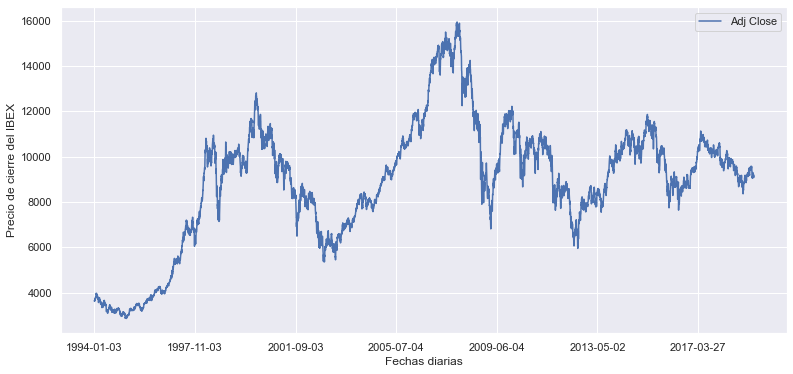

In [21]:
sns.set(rc = {"figure.figsize":(13,6)}) # Definimos el tamaño de la imagen
ax = train_data[['Adj Close']].plot(linestyle = '-')
ax.set_ylabel("Precio de cierre del IBEX") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

Podemos observar la evoluación de nuestra serie temporal no tiene, a priori, ningún valor atípico raro. Luego, podemos concluir que la serie está correctamente definida. 

Para comprobar que efectivamente la variable Target está bien definida, utilizaremos una función que nos ayudará a determinarlo.

In [22]:
target_correcto(train_data, 'Adj Close', 'Target', 3)

True

Comprobamos que nuestra variable Target está correctamente definida. Buenas noticias.

## Modelado

En esta sección plantearemos diferentes algoritmos y, nos quedaremos con el que mejor resultados nos genere. Para ello, necesitaremos generar un conjunto de training, otro de validación y, finalmente, otro de testing.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_data['Adj Close'], train_data['Target'], test_size=0.15, shuffle=True, random_state=8)

In [24]:
X_train.shape, y_train.shape

((5570,), (5570,))

In [25]:
X_train, y_train, X_test, y_test = pd.DataFrame(X_train), pd.DataFrame(y_train), pd.DataFrame(X_test), pd.DataFrame(y_test)

En primer lugar plantearemos un RandomForest, conocido algoritmo de bagging de árboles de decisión

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       469
           1       0.55      0.55      0.55       515

    accuracy                           0.53       984
   macro avg       0.53      0.53      0.53       984
weighted avg       0.53      0.53      0.53       984



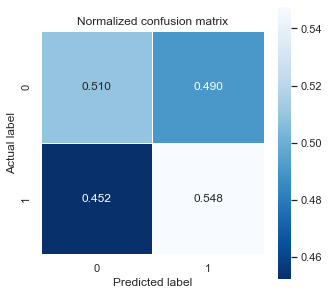

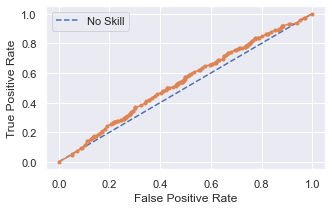

In [26]:
prediction_RF, predictions_proba_RF = model(X_train, y_train, X_test, RandomForestClassifier(), y_test)

Probemos ahora con un XGBoost:

[18:12:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.39      0.44       469
           1       0.55      0.67      0.60       515

    accuracy                           0.54       984
   macro avg       0.53      0.53      0.52       984
weighted avg       0.53      0.54      0.53       984



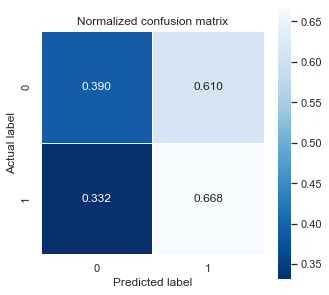

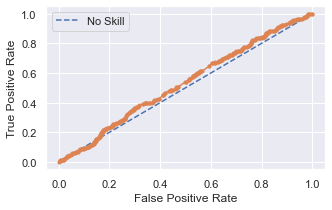

In [27]:
prediction_XGB, predictions_proba_XGB = model(X_train, y_train, X_test, XGBClassifier(), y_test)

Probemos, finalmente, con un LightGBM

              precision    recall  f1-score   support

           0       0.50      0.37      0.43       469
           1       0.54      0.66      0.59       515

    accuracy                           0.52       984
   macro avg       0.52      0.52      0.51       984
weighted avg       0.52      0.52      0.51       984



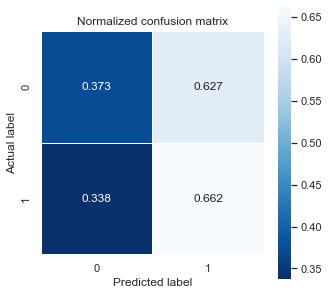

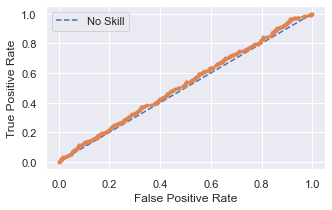

In [28]:
prediction_LGBM, predictions_proba_LGBM = model(X_train, y_train, X_test, lgb.LGBMClassifier(), y_test)

Comprobemos el valor de las métricas AUC y f1 para cada uno de los modelos:

Random Forest

In [29]:
f1_RF = f1_score(prediction_RF, y_test)

In [30]:
AUC_RF = roc_auc_score(prediction_RF, y_test)

XGBoost

In [31]:
f1_XGB = f1_score(prediction_XGB, y_test)

In [32]:
AUC_XGB = roc_auc_score(prediction_XGB, y_test)

LightGBM

In [33]:
f1_LGBM = f1_score(prediction_LGBM, y_test)

In [34]:
AUC_LGBM = roc_auc_score(prediction_LGBM, y_test)

In [35]:
df_comparar = pd.DataFrame({'RF' : [f1_RF, AUC_RF], 'XGB' : [f1_XGB, AUC_XGB], 'LGBM' : [f1_LGBM, AUC_LGBM]})

In [36]:
df_comparar.index = ['f1', 'AUC']
df_comparar

,RF,XGB,LGBM
f1,0.549172,0.600873,0.593043
AUC,0.528569,0.531490,0.519220


Ahora bien, ya vistos los resultados, comprobamos que el mejor modelo es el XGBoost. Veamos ahora cómo evolucionan las métricas en función del valor del threshold.

In [37]:
XGB_medidas = maximize_scores(predictions_proba_XGB, y_test)

Veamos con qué punto de corte se da el mejor rendimiento:

<AxesSubplot:>

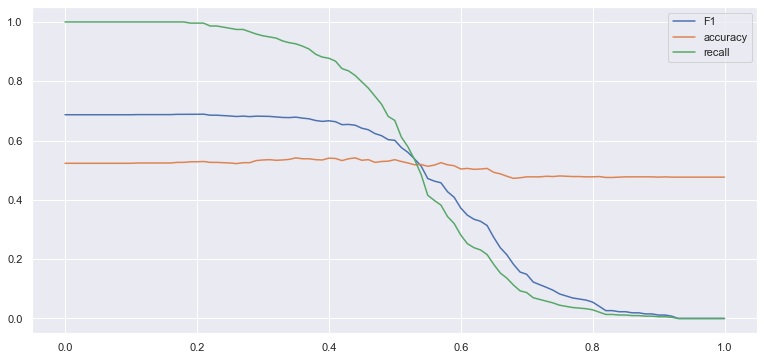

In [38]:
XGB_medidas.plot()

Parece que se encuentra cerca de 0.5, hagamos zoom:

<AxesSubplot:>

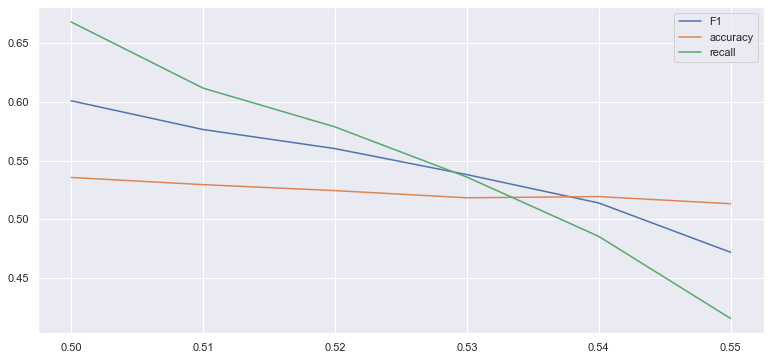

In [39]:
XGB_medidas[0.5:0.55].plot()

Sin embargo, en esta ocasión nos centraremos en maximizar el f1_score, ya que es el principal objetivo 

### Optimización de hiperparámetros

Una vez visto que el mejor de los modelos es el XGBoost, procedemos a realizar la búsqueda de los mejores hiperparámetros del modelo para encontrar mejores resultados todavía.  

Sin embargo, no intentaré maximizar el f1_score, sino que intentaré maximizar el roc_auc_score.

In [40]:
XGB = Pipeline(steps=[('model', XGBClassifier(random_state=8, use_label_encoder=False))])

In [41]:
param_grid_xgb = {
    "model__subsample":[0.5, 0.75, 1],
    "model__colsample_bytree":[0.5, 0.75, 1],
    "model__max_depth":[6, 10, 14, 18],
    "model__min_child_weight":[1,5,15],
    "model__learning_rate":[0.3, 0.1, 0.03, 0.01],
    "model__n_estimators":[50, 100, 150]
    }

In [ ]:
CV = RandomizedSearchCV(XGB, param_grid_xgb, cv=10, random_state=42, n_jobs=2, scoring='f1', )
                  
BM_XGB = CV.fit(X_train, y_train)  
print(CV.best_params_)    

Consideremos entonces el modelo lightgbm con los siguientes hiperparámetros:
- subsample = 0.5
- n_estimators = 150
- min_child_weight = 1
- max_depth = 6
- learning_rate = 0.01
- colsample_bytree = 0.5

In [ ]:
prediction_XGB, predictions_proba_XGB = model(X_train, y_train, X_test, XGBClassifier(subsample=0.5, n_estimators=150, min_child_weight=1, max_depth=6, learning_rate=0.01, colsample_bytree=0.55), y_test)

In [ ]:
f1_score(prediction_XGB, y_test)

Finalmente, se concluye que el mejor de los modelos es el modelo XGBoost con la optimización de hiperparámetros. Con este modelo se llega a obtener un valor de f1 de 0.649.

## Predicción del conjunto de Test

In [ ]:
test_data = pd.read_csv('../data/test_x.csv')

In [ ]:
final_results = test_data[:]

In [ ]:
final_results.index = final_results['test_index']

In [ ]:
test_data.index = test_data['Date']
test_data = test_data[['Adj Close']]

In [ ]:
test_data.head()

In [ ]:
predictions = BM_XGB.predict(test_data)

In [ ]:
final_results['Target'] = predictions

In [ ]:
final_results = final_results[['Target']]

### Guardado de resultados

In [ ]:
final_results.to_csv('predictions.csv')

In [ ]:
final_results.to_json('predictions.json')